In [50]:
import numpy as np
import pandas as pd
import random
import xgboost as xgb

from dtreeviz.trees import *
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [2]:
seed = 444

random.seed(seed)
np.random.seed(seed)

# 二分类

In [3]:
data = load_breast_cancer()
X = data.data
Y = data.target
test_ratio = 0.2


print(X.shape, Y.shape)

(569, 30) (569,)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_ratio, random_state=seed)

In [39]:
dtrain = xgb.DMatrix(x_train, y_train, feature_names=data.feature_names)
dtest = xgb.DMatrix(x_test[:10], y_test[:10], feature_names=data.feature_names)

In [40]:
params = {
    "objective": "binary:logistic",
    "booster": "gbtree", 
    "max_depth": 3, 
}
num_estimators = 3
watch_list = [(dtrain, "train"), (dtest, "eval")]

In [41]:
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_estimators, evals=watch_list)

[13:10:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.46400	eval-logloss:0.44367
[1]	train-logloss:0.33392	eval-logloss:0.30305
[2]	train-logloss:0.25276	eval-logloss:0.22352


In [45]:
model.dump_model("breast_cancer_binary_logistic.txt")

In [46]:
pred = model.predict(dtest)
pred

array([0.25689885, 0.80514336, 0.80514336, 0.80514336, 0.80514336,
       0.19154955, 0.80514336, 0.19154955, 0.80514336, 0.19154955],
      dtype=float32)

In [70]:
model.predict(dtest)

array([0.25689885, 0.80514336, 0.80514336, 0.80514336, 0.80514336,
       0.19154955, 0.80514336, 0.19154955, 0.80514336, 0.19154955],
      dtype=float32)

In [88]:
# 模型原始的输出值 --- 转化为概率之前的值
ypred_margin = model.predict(dtest, output_margin=True)  # , iteration_range=(0,1))
ypred_margin

array([-1.0621498,  1.4187561,  1.4187561,  1.4187561,  1.4187561,
       -1.4399728,  1.4187561, -1.4399728,  1.4187561, -1.4399728],
      dtype=float32)

In [95]:
model.predict(dtest.slice([0,1]), pred_contribs=1)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.04161034,  0.        ,  0.        ,
         0.00295137, -0.02263654,  0.        , -0.11660431,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.1112702 , -0.01668743, -0.38545   ,  0.        ,  0.        ,
         0.        ,  0.22617589,  0.04352571,  0.        ,  0.        ,
         0.35945606],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.10218991,  0.        ,  0.        ,
         0.00757839, -0.00416938,  0.        ,  0.00671936,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.47861928,  0.01613794,  0.19364637,  0.        ,  0.        ,
         0.        ,  0.15136893,  0.10720918,  0.        ,  0.        ,
         0.35945606]], dtype=float32)

In [76]:
1 / (1 + np.exp(-ypred_margin))

array([0.25689885, 0.80514336, 0.80514336, 0.80514336, 0.80514336,
       0.19154955, 0.80514336, 0.19154955, 0.80514336, 0.19154955],
      dtype=float32)

In [48]:
# 原始输出值所在的叶子节点下标
ypred_leaf = model.predict(dtest, pred_leaf=True)
ypred_leaf

array([[12., 14.,  9.],
       [ 7.,  7.,  7.],
       [ 7.,  7.,  7.],
       [ 7.,  7.,  7.],
       [ 7.,  7.,  7.],
       [12., 14., 10.],
       [ 7.,  7.,  7.],
       [12., 14., 10.],
       [ 7.,  7.,  7.],
       [12., 14., 10.]], dtype=float32)

<AxesSubplot:>

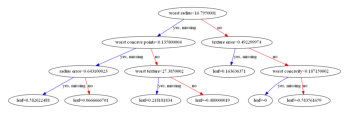

In [64]:
xgb.plot_tree(model, rounded=True)  # feature_names=data.feature_names.tolist(), class_names=data.target_names.tolist(),  filled=True

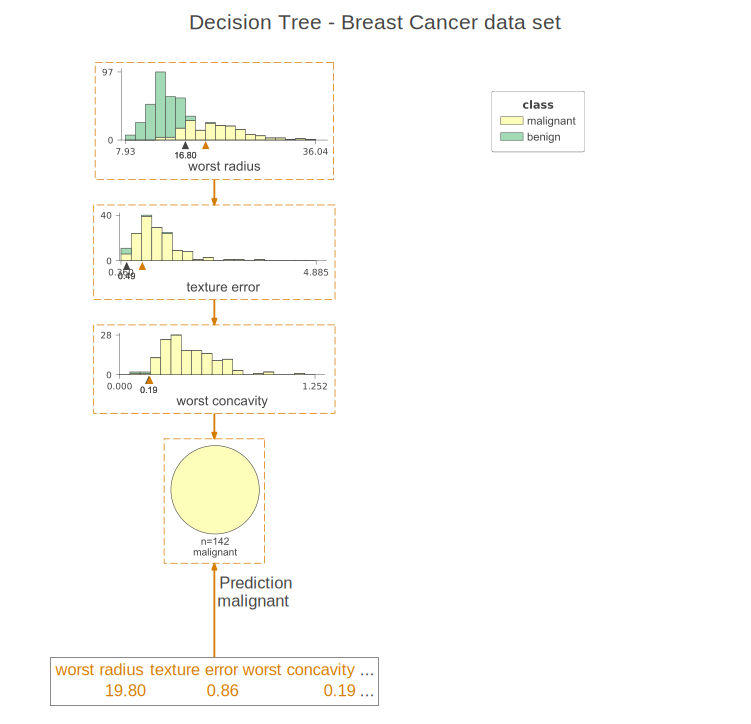

In [86]:
viz = dtreeviz(model, 
               tree_index=0,
               x_data=x_train,
               y_data=y_train,
               X=x_test[0],  # 可视化有一个样本的分类过程
               show_just_path=1,  # 是否只展示预测过程
               fancy=1,  # 是否进行美化
               target_name='class',
               feature_names=data.feature_names.tolist(), 
               class_names=list(data.target_names), 
               title="Decision Tree - Breast Cancer data set",
               scale=1.5)
viz

In [63]:
x_train.shape

(455, 30)

## 总结

关于参数的一些解释：
- `binary:logistic`: 这个表示目标函数使用的是逻辑回归中常用的损失函数 cross-entropy 损失函数。因此，对于每一棵树，**其实每个叶子节点的值是逻辑回归中的** $\theta * x$；
- `num_boost_round`: 即提升的次数，对于基学习器为树时，就是决策树的数量，对于线性模型（如 `gblinear`）就等同于 epoch，即在数据集上迭代的次数；

关于预测的一些解释：
- model.predict 输出的是每个样本属于 1 的概率值。